# Importowanie bibliotek

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Wczytywanie i Przygotowanie Zestawu Danych

In [24]:
# Ustawienie transformacji
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżki do danych
train_dir = 'car_data/train'
test_dir = 'car_data/test'

# Wczytywanie danych
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Definiowanie Modelu

In [25]:
class CarClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CarClassifier, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

num_classes = len(train_dataset.classes)
model = CarClassifier(num_classes)

# Ustawienie Parametrów Treningowych

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pętla Treningowa

In [27]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 4.45818156448065
Epoch 2, Loss: 2.3523852946711523
Epoch 3, Loss: 1.2334656238555908
Epoch 4, Loss: 0.6732015304705676
Epoch 5, Loss: 0.40773997423695585
Epoch 6, Loss: 0.2541955489446135
Epoch 7, Loss: 0.18196467082290088
Epoch 8, Loss: 0.14107637439726614
Epoch 9, Loss: 0.11139256274875473
Epoch 10, Loss: 0.13364528002692203


# Testowanie Modelu

In [28]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Dokładność modelu na zestawie testowym: {accuracy}%')

Dokładność modelu na zestawie testowym: 65.41474940927745%


# Zapisywanie Modelu

In [29]:
torch.save(model.state_dict(), 'car_classifier_model.pth')

# Wczytywanie Modelu

In [34]:
model = CarClassifier(num_classes)
model.load_state_dict(torch.load('car_classifier_model.pth'))
model.eval()

CarClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

# Wizualizacja losowych wyników

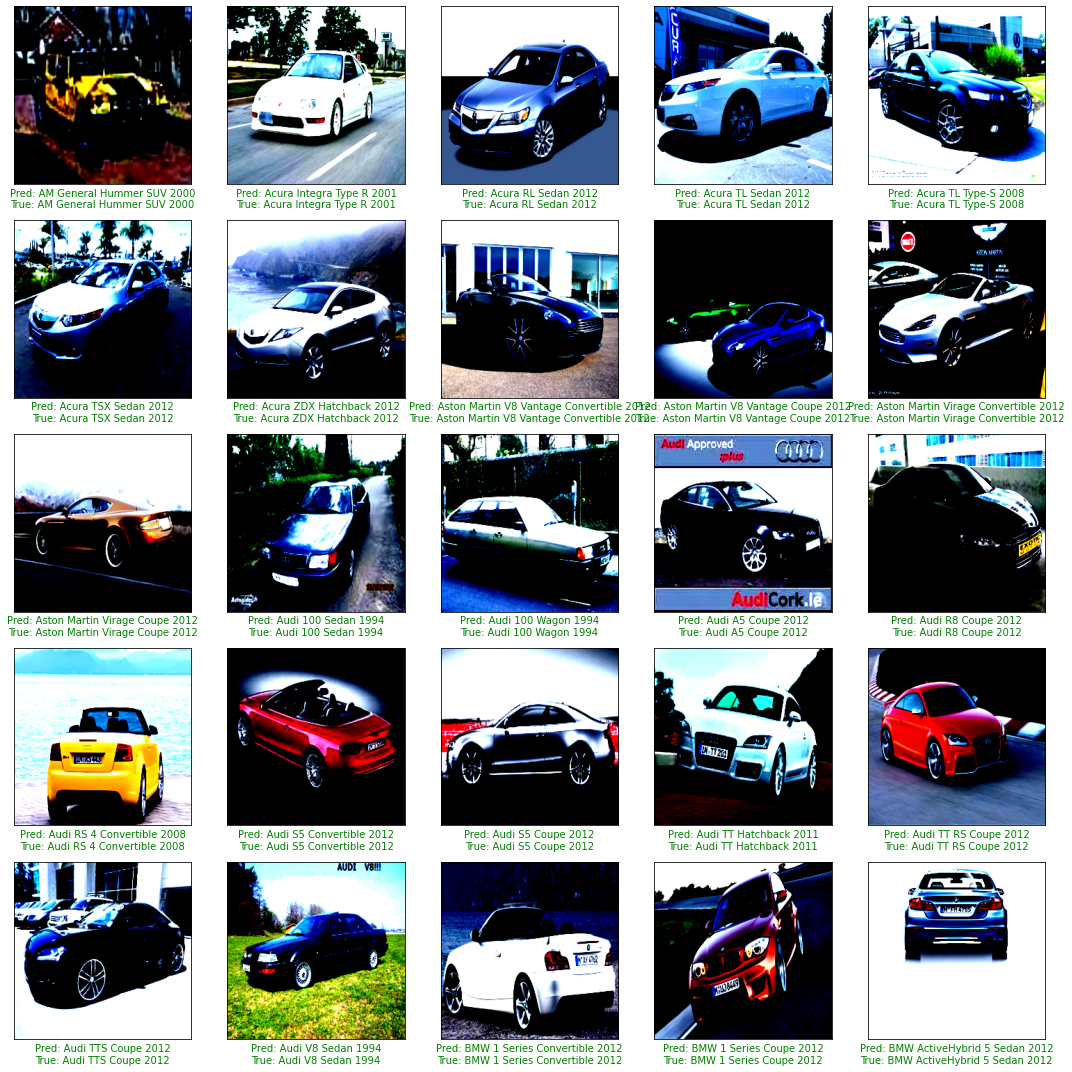

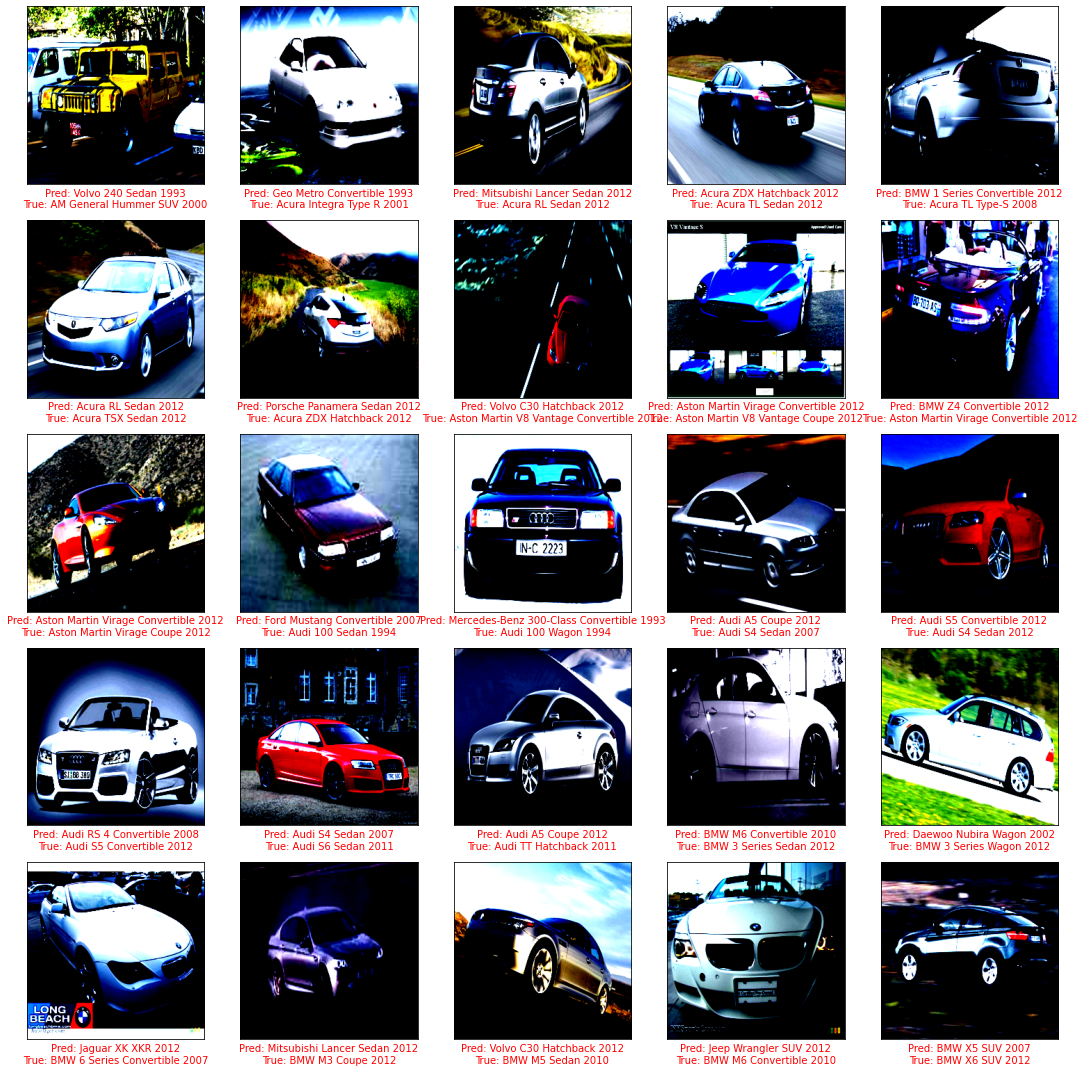

In [40]:
import matplotlib.pyplot as plt
from collections import defaultdict

def display_images(images, labels, preds, classes):
    num_images = min(len(images), 25)
    rows = num_images // 5 + int(num_images % 5 > 0)  # Dodajemy wiersz, jeśli potrzeba
    cols = 5 if num_images > 4 else num_images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0)  # Tensors in CxHxW to HxWxC format for matplotlib
        img = img.cpu().numpy()
        img = np.clip(img, 0, 1)  # Ustalenie zakresu wartości do prawidłowego wyświetlania
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_xlabel(f'Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}', color=color)

    plt.tight_layout()
    plt.show()

model.eval()
correct_samples = defaultdict(int)
incorrect_samples = defaultdict(int)
correct_images, correct_labels, correct_preds = [], [], []
incorrect_images, incorrect_labels, incorrect_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for image, label, pred in zip(images, labels, preds):
            if label == pred and correct_samples[label.item()] < 1:
                correct_images.append(image)
                correct_labels.append(label)
                correct_preds.append(pred)
                correct_samples[label.item()] += 1
            elif label != pred and incorrect_samples[label.item()] < 1:
                incorrect_images.append(image)
                incorrect_labels.append(label)
                incorrect_preds.append(pred)
                incorrect_samples[label.item()] += 1
            if len(correct_images) + len(incorrect_images) >= 25:
                break

classes = test_dataset.classes
display_images(correct_images, correct_labels, correct_preds, classes)
display_images(incorrect_images, incorrect_labels, incorrect_preds, classes)